In [27]:
pip install optuna

   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   --- ------------------------------------ 30.7/386.6 kB ? eta -:--:--
   --- ------------------------------------ 30.7/386.6 kB ? eta -:--:--
   --------- ----------------------------- 92.2/386.6 kB 871.5 kB/s eta 0:00:01
   --------- ----------------------------- 92.2/386.6 kB 871.5 kB/s eta 0:00:01
   ------------------ ------------------- 184.3/386.6 kB 926.0 kB/s eta 0:00:01
   ------------------ ------------------- 184.3/386.6 kB 926.0 kB/s eta 0:00:01
   ---------------------------- --------- 286.7/386.6 kB 983.9 kB/s eta 0:00:01
   ---------------------------- --------- 286.7/386.6 kB 983.9 kB/s eta 0:00:01
   ---------------------------------------- 386.6/386.6 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/242.5 kB ? eta -:--:--
   --------------- ------------------------ 92.2/242.5 kB ? eta -:--:--
   --------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [11]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import optuna
import time


In [1]:
# Dataset path
dataset_path = r"C:\Users\Pang Yong Seng\Desktop\FYP\FYP 2\dataset\Car-Model-Data"


In [3]:
# Create augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])


Found 14 classes
Counting images before augmentation...


Counting original images: 100%|██████████| 14/14 [00:00<00:00, 279.73it/s]


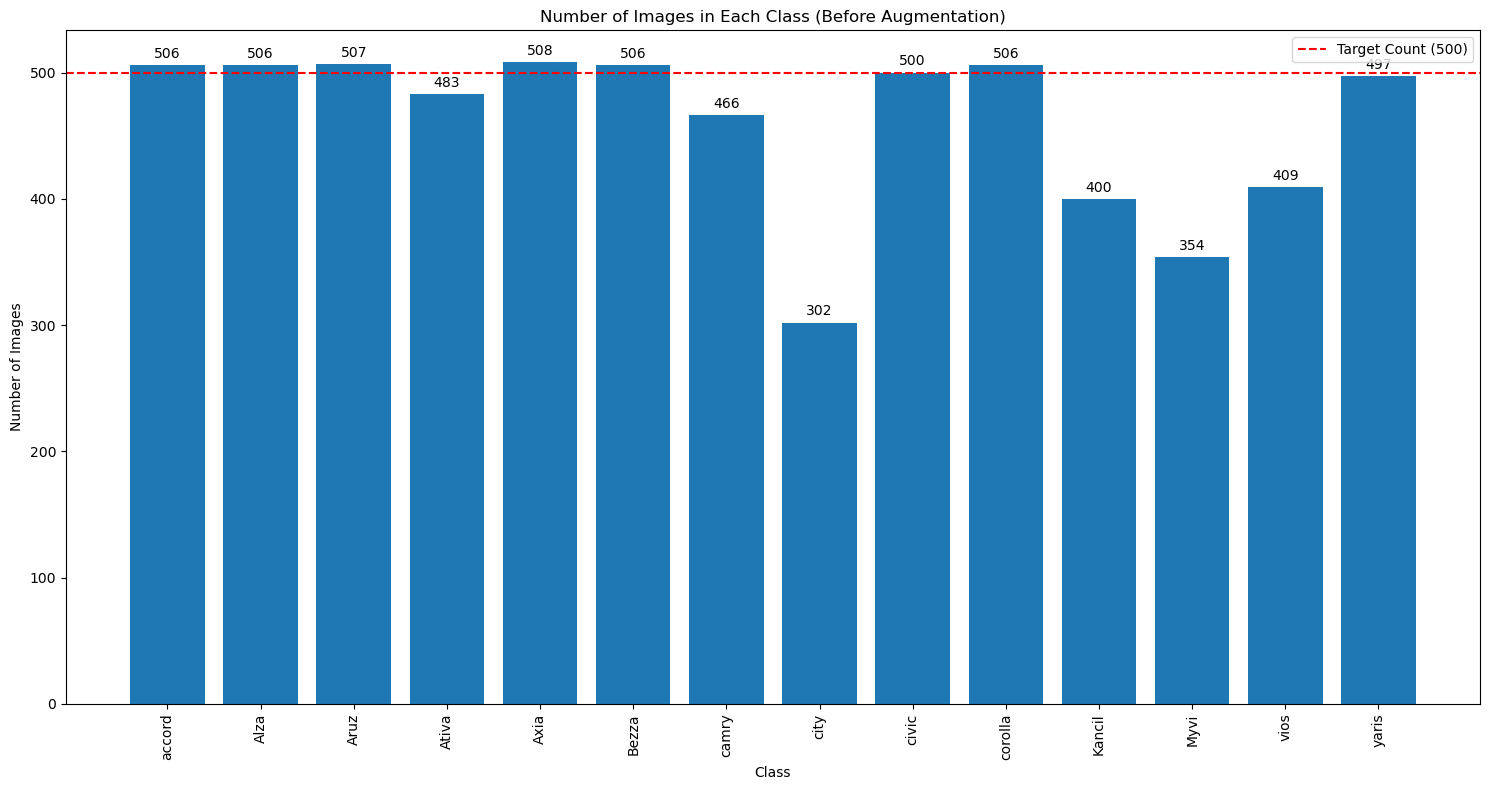

In [4]:
# Process each class and add augmented images directly to original folders
class_counts_before = {}
class_counts_after = {}
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and d != "augmented"]

print(f"Found {len(classes)} classes")

# Count images before augmentation
print("Counting images before augmentation...")
for class_name in tqdm(classes, desc="Counting original images"):
    class_dir = os.path.join(dataset_path, class_name)
    
    # Get all original images in this class
    original_images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')) 
                      and not f.startswith('aug_')]
    
    num_original_images = len(original_images)
    class_counts_before[class_name] = num_original_images

# Visualize before augmentation
class_names = list(class_counts_before.keys())
class_counts = list(class_counts_before.values())

plt.figure(figsize=(15, 8))
bars = plt.bar(class_names, class_counts)
plt.title('Number of Images in Each Class (Before Augmentation)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.axhline(y=500, color='r', linestyle='--', label='Target Count (500)')
plt.legend()
plt.show()

In [5]:
# Process each class for augmentation
for class_name in tqdm(classes, desc="Processing classes for augmentation"):
    class_dir = os.path.join(dataset_path, class_name)
    
    # Get all original images in this class
    original_images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')) 
                      and not f.startswith('aug_')]
    
    num_original_images = len(original_images)
    
    # Count all images (including any pre-existing augmented ones)
    all_images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(all_images)
    
    print(f"Class: {class_name}, Original Images: {num_original_images}, Current Total: {current_count}")
    
    # If class has less than 500 images, augment
    if current_count < 500:
        num_to_augment = 500 - current_count
        
        # Choose random images to augment from original images only (with replacement if necessary)
        images_to_augment = random.choices(original_images, k=num_to_augment)
        
        for i, img_file in enumerate(tqdm(images_to_augment, desc=f"Augmenting {class_name}", leave=False)):
            img_path = os.path.join(class_dir, img_file)
            try:
                # Open image and verify it's valid
                img = Image.open(img_path).convert('RGB')
                
                # Apply augmentation
                augmented_img = augmentation_transforms(img)
                
                # Save augmented image in the same directory as original
                save_path = os.path.join(class_dir, f"aug_{i}_{img_file}")
                augmented_img.save(save_path)
                
                # Verify the saved file exists and is valid
                if not os.path.exists(save_path):
                    print(f"Warning: Failed to save {save_path}")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Verify all files exist after augmentation
print("\nVerifying all files exist...")
missing_files = []
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    all_images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in all_images:
        img_path = os.path.join(class_dir, img_file)
        if not os.path.exists(img_path):
            missing_files.append(img_path)

if missing_files:
    print(f"Found {len(missing_files)} missing files:")
    for file in missing_files[:10]:  # Show first 10
        print(f"  - {file}")
    if len(missing_files) > 10:
        print(f"  ... and {len(missing_files) - 10} more")
else:
    print("All files verified!")


Processing classes for augmentation:   0%|          | 0/14 [00:00<?, ?it/s]

Class: accord, Original Images: 506, Current Total: 506
Class: Alza, Original Images: 506, Current Total: 506
Class: Aruz, Original Images: 507, Current Total: 507
Class: Ativa, Original Images: 483, Current Total: 483


Processing classes for augmentation:  29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

Class: Axia, Original Images: 508, Current Total: 508
Class: Bezza, Original Images: 506, Current Total: 506
Class: camry, Original Images: 466, Current Total: 466


Processing classes for augmentation:  50%|█████     | 7/14 [00:02<00:02,  2.70it/s]

Class: city, Original Images: 302, Current Total: 302


Processing classes for augmentation:  57%|█████▋    | 8/14 [00:07<00:07,  1.28s/it]

Class: civic, Original Images: 500, Current Total: 500
Class: corolla, Original Images: 506, Current Total: 506
Class: Kancil, Original Images: 400, Current Total: 400


Processing classes for augmentation:  79%|███████▊  | 11/14 [00:11<00:03,  1.29s/it]

Class: Myvi, Original Images: 354, Current Total: 354


Processing classes for augmentation:  86%|████████▌ | 12/14 [00:14<00:03,  1.52s/it]

Class: vios, Original Images: 409, Current Total: 409


Processing classes for augmentation:  93%|█████████▎| 13/14 [00:15<00:01,  1.48s/it]

Class: yaris, Original Images: 497, Current Total: 497


Processing classes for augmentation: 100%|██████████| 14/14 [00:15<00:00,  1.10s/it]



Verifying all files exist...
All files verified!



Counting images after augmentation...


Counting after augmentation: 100%|██████████| 14/14 [00:00<00:00, 1400.67it/s]

accord: 506 original + 0 augmented = 506 total
Alza: 506 original + 0 augmented = 506 total
Aruz: 507 original + 0 augmented = 507 total
Ativa: 483 original + 17 augmented = 500 total
Axia: 508 original + 0 augmented = 508 total
Bezza: 506 original + 0 augmented = 506 total
camry: 466 original + 34 augmented = 500 total
city: 302 original + 198 augmented = 500 total
civic: 500 original + 0 augmented = 500 total
corolla: 506 original + 0 augmented = 506 total
Kancil: 400 original + 100 augmented = 500 total
Myvi: 354 original + 146 augmented = 500 total
vios: 409 original + 91 augmented = 500 total
yaris: 497 original + 3 augmented = 500 total


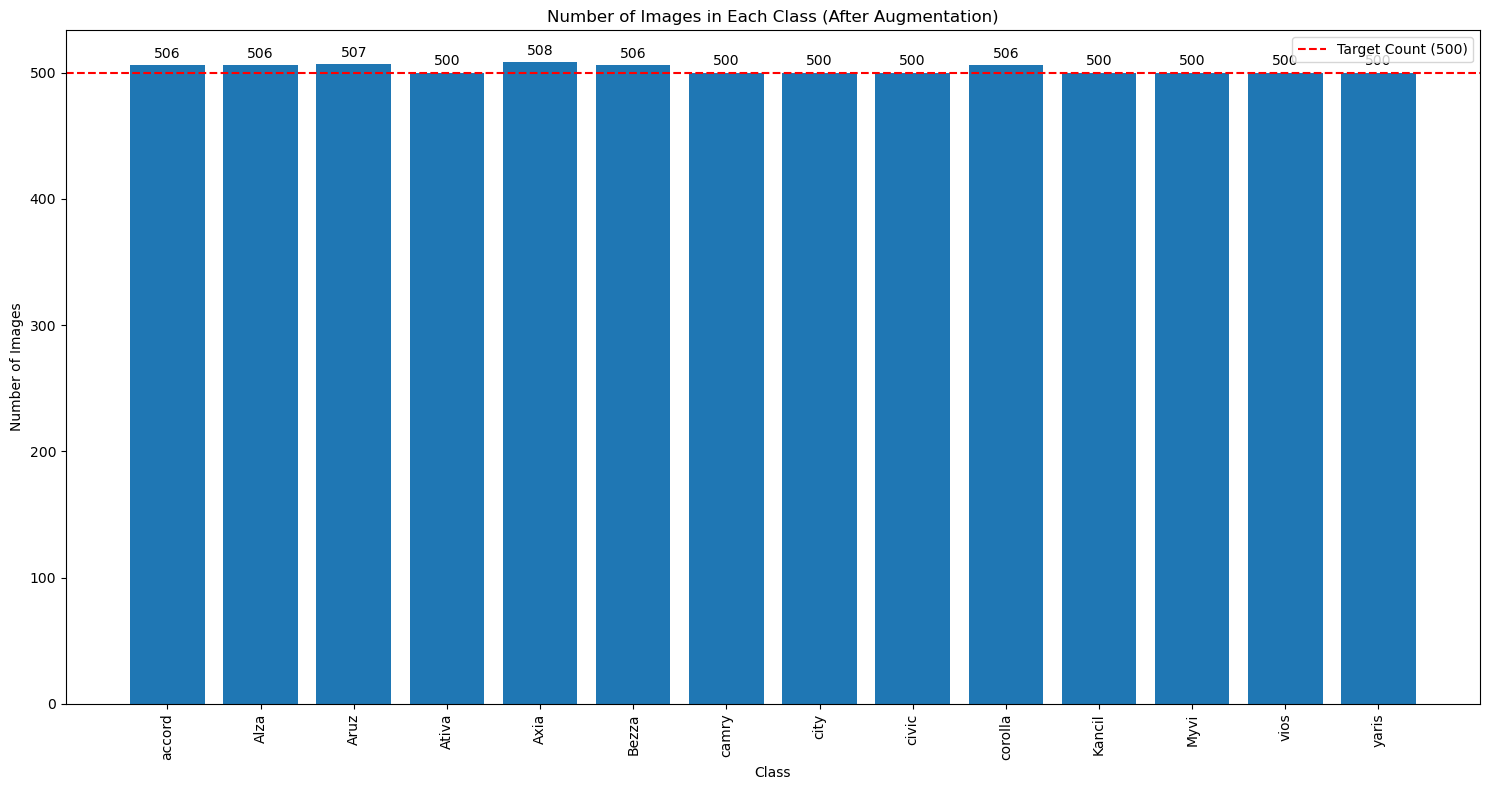

In [6]:
# Count images after augmentation
print("\nCounting images after augmentation...")
for class_name in tqdm(classes, desc="Counting after augmentation"):
    class_dir = os.path.join(dataset_path, class_name)
    all_images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    original_images = [f for f in all_images if not f.startswith('aug_')]
    augmented_images = [f for f in all_images if f.startswith('aug_')]
    
    class_counts_after[class_name] = len(all_images)
    
    print(f"{class_name}: {len(original_images)} original + {len(augmented_images)} augmented = {len(all_images)} total")

# Create a bar chart showing the count AFTER augmentation
plt.figure(figsize=(15, 8))
class_names = list(class_counts_after.keys())
after_counts = list(class_counts_after.values())

bars = plt.bar(class_names, after_counts)
plt.title('Number of Images in Each Class (After Augmentation)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.axhline(y=500, color='r', linestyle='--', label='Target Count (500)')
plt.legend()
plt.show()


In [12]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [13]:
# Define paths
dataset_root = "dataset/Car-Model-Data"
original_data_dir = os.path.join(dataset_root, "original")  # Assuming this is where your original images are
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")

In [14]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [15]:
# Function to split and copy images
def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8):
    # Get all class folders
    class_folders = [d for d in os.listdir(source_dir) 
                     if os.path.isdir(os.path.join(source_dir, d))]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")
    
    # Process each class folder
    for class_name in tqdm(class_folders, desc="Processing classes"):
        # Create class directories in train and val
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        # Get all images for this class
        class_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        # Shuffle images
        random.shuffle(images)
        
        # Calculate split point
        split_idx = int(len(images) * split_ratio)
        
        # Split into train and validation sets
        train_images = images[:split_idx]
        val_images = images[split_idx:]
        
        print(f"  {class_name}: {len(train_images)} train, {len(val_images)} validation")
        
        # Copy images to train folder
        for img in tqdm(train_images, desc=f"Copying {class_name} train images", leave=False):
            src = os.path.join(class_path, img)
            dst = os.path.join(train_class_dir, img)
            shutil.copy2(src, dst)
        
        # Copy images to validation folder
        for img in tqdm(val_images, desc=f"Copying {class_name} validation images", leave=False):
            src = os.path.join(class_path, img)
            dst = os.path.join(val_class_dir, img)
            shutil.copy2(src, dst)

In [17]:
# Main execution
def main():
    # Check if dataset directory exists
    if not os.path.exists(original_data_dir):
        print(f"Error: Dataset directory {original_data_dir} not found.")
        print("Please check the path or update the script.")
        return
    
    print(f"Splitting dataset with {split_ratio*100:.0f}% train, {(1-split_ratio)*100:.0f}% validation")
    
    # Check the structure of the dataset
    is_class_organized = any(os.path.isdir(os.path.join(original_data_dir, d)) 
                           for d in os.listdir(original_data_dir))
    
    if is_class_organized:
        print("Dataset appears to be organized by class folders")
        split_dataset(original_data_dir, train_dir, val_dir)
    else:
        print("Dataset appears to be a flat directory")
        split_flat_dataset(original_data_dir, train_dir, val_dir)
    
    # Count files to verify
    train_count = sum(len(files) for _, _, files in os.walk(train_dir))
    val_count = sum(len(files) for _, _, files in os.walk(val_dir))
    total = train_count + val_count
    
    print("\nDataset splitting complete!")
    print(f"Total images: {total}")
    print(f"Training images: {train_count} ({train_count/total*100:.2f}%)")
    print(f"Validation images: {val_count} ({val_count/total*100:.2f}%)")

if __name__ == "__main__":
    # Set your desired split ratio here (0.8 = 80% train, 20% validation)
    split_ratio = 0.8
    main()

Splitting dataset with 80% train, 20% validation
Dataset appears to be organized by class folders
Found 14 classes: ['accord', 'Alza', 'Aruz', 'Ativa', 'Axia', 'Bezza', 'camry', 'city', 'civic', 'corolla', 'Kancil', 'Myvi', 'vios', 'yaris']


Processing classes:   0%|          | 0/14 [00:00<?, ?it/s]

  accord: 404 train, 102 validation


Processing classes:   7%|▋         | 1/14 [00:04<00:56,  4.33s/it]

  Alza: 404 train, 102 validation


Processing classes:  14%|█▍        | 2/14 [00:08<00:52,  4.34s/it]

  Aruz: 405 train, 102 validation


Processing classes:  21%|██▏       | 3/14 [00:13<00:48,  4.38s/it]

  Ativa: 400 train, 100 validation


Processing classes:  29%|██▊       | 4/14 [00:17<00:43,  4.38s/it]

  Axia: 406 train, 102 validation


Processing classes:  36%|███▌      | 5/14 [00:21<00:39,  4.40s/it]

  Bezza: 404 train, 102 validation


Processing classes:  43%|████▎     | 6/14 [00:26<00:35,  4.43s/it]

  camry: 400 train, 100 validation


Processing classes:  50%|█████     | 7/14 [00:30<00:30,  4.41s/it]

  city: 400 train, 100 validation


Processing classes:  57%|█████▋    | 8/14 [00:34<00:26,  4.34s/it]

  civic: 400 train, 100 validation


Processing classes:  64%|██████▍   | 9/14 [00:39<00:21,  4.31s/it]

  corolla: 404 train, 102 validation


Processing classes:  71%|███████▏  | 10/14 [00:43<00:17,  4.32s/it]

  Kancil: 400 train, 100 validation


Processing classes:  79%|███████▊  | 11/14 [00:47<00:12,  4.27s/it]

  Myvi: 400 train, 100 validation


Processing classes:  86%|████████▌ | 12/14 [00:51<00:08,  4.15s/it]

  vios: 400 train, 100 validation


Processing classes:  93%|█████████▎| 13/14 [00:55<00:04,  4.06s/it]

  yaris: 400 train, 100 validation


Processing classes: 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]


Dataset splitting complete!
Total images: 7039
Training images: 5627 (79.94%)
Validation images: 1412 (20.06%)


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Set paths and parameters
data_dir = "dataset/Car-Model-Data"
num_classes = 14
batch_size = 32
num_epochs = 20
learning_rate = 0.001

Using cuda device


In [9]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [18]:
# Load data
print("Loading dataset...")
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print class information
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Loading dataset...
Classes: ['Alza', 'Aruz', 'Ativa', 'Axia', 'Bezza', 'Kancil', 'Myvi', 'accord', 'camry', 'city', 'civic', 'corolla', 'vios', 'yaris']
Number of training samples: 5627
Number of validation samples: 1412


In [19]:
# Load pre-trained ResNet-50 model and modify the final layer
model = models.resnet50(weights='IMAGENET1K_V2')


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Pang Yong Seng/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:44<00:00, 2.31MB/s]


In [20]:
# Freeze early layers to speed up training
for param in list(model.parameters())[:-2*4]:  # Freeze all except the last 2 layers
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [22]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_bar.set_postfix({'loss': loss.item(), 'acc': val_correct/val_total})
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [23]:
# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

Epoch 1/20 [Val]: 100%|██████████| 45/45 [00:17<00:00,  2.51it/s, loss=1.13, acc=0.576] 


Epoch 1/20: Train Loss: 1.6756, Train Acc: 0.4526, Val Loss: 1.2597, Val Acc: 0.5758


Epoch 2/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.81it/s, loss=1.79, acc=0.668] 


Epoch 2/20: Train Loss: 0.7399, Train Acc: 0.7731, Val Loss: 1.0117, Val Acc: 0.6678


Epoch 3/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.81it/s, loss=0.75, acc=0.655] 


Epoch 3/20: Train Loss: 0.3707, Train Acc: 0.8870, Val Loss: 1.1098, Val Acc: 0.6551


Epoch 4/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.74it/s, loss=1.49, acc=0.695]  


Epoch 4/20: Train Loss: 0.1939, Train Acc: 0.9470, Val Loss: 1.0237, Val Acc: 0.6955


Epoch 5/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.85it/s, loss=0.602, acc=0.691] 


Epoch 5/20: Train Loss: 0.1112, Train Acc: 0.9691, Val Loss: 1.0925, Val Acc: 0.6905


Epoch 6/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.79it/s, loss=0.859, acc=0.712] 


Epoch 6/20: Train Loss: 0.0736, Train Acc: 0.9810, Val Loss: 1.0384, Val Acc: 0.7118


Epoch 7/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.83it/s, loss=1.01, acc=0.734]  


Epoch 7/20: Train Loss: 0.0353, Train Acc: 0.9941, Val Loss: 0.9853, Val Acc: 0.7337


Epoch 8/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.77it/s, loss=1.31, acc=0.737]   


Epoch 8/20: Train Loss: 0.0228, Train Acc: 0.9968, Val Loss: 0.9478, Val Acc: 0.7373


Epoch 9/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.86it/s, loss=1.12, acc=0.736]  


Epoch 9/20: Train Loss: 0.0202, Train Acc: 0.9964, Val Loss: 0.9540, Val Acc: 0.7358


Epoch 10/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.85it/s, loss=0.958, acc=0.734] 


Epoch 10/20: Train Loss: 0.0158, Train Acc: 0.9986, Val Loss: 0.9652, Val Acc: 0.7344


Epoch 11/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.83it/s, loss=1.11, acc=0.741]  


Epoch 11/20: Train Loss: 0.0138, Train Acc: 0.9989, Val Loss: 0.9465, Val Acc: 0.7408


Epoch 12/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.83it/s, loss=1.22, acc=0.734]  


Epoch 12/20: Train Loss: 0.0146, Train Acc: 0.9979, Val Loss: 0.9673, Val Acc: 0.7337


Epoch 13/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s, loss=1.38, acc=0.729] 


Epoch 13/20: Train Loss: 0.0128, Train Acc: 0.9977, Val Loss: 0.9634, Val Acc: 0.7295


Epoch 14/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.87it/s, loss=1.05, acc=0.735]  


Epoch 14/20: Train Loss: 0.0092, Train Acc: 0.9989, Val Loss: 0.9689, Val Acc: 0.7351


Epoch 15/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s, loss=1.31, acc=0.739]   


Epoch 15/20: Train Loss: 0.0106, Train Acc: 0.9984, Val Loss: 0.9715, Val Acc: 0.7394


Epoch 16/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.87it/s, loss=1.34, acc=0.738] 


Epoch 16/20: Train Loss: 0.0097, Train Acc: 0.9988, Val Loss: 0.9747, Val Acc: 0.7380


Epoch 17/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s, loss=1.29, acc=0.731]  


Epoch 17/20: Train Loss: 0.0090, Train Acc: 0.9984, Val Loss: 0.9569, Val Acc: 0.7309


Epoch 18/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s, loss=1.43, acc=0.743]   


Epoch 18/20: Train Loss: 0.0075, Train Acc: 0.9995, Val Loss: 0.9580, Val Acc: 0.7429


Epoch 19/20 [Val]: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s, loss=0.932, acc=0.737] 


Epoch 19/20: Train Loss: 0.0093, Train Acc: 0.9986, Val Loss: 0.9785, Val Acc: 0.7365


Epoch 20/20 [Val]: 100%|██████████| 45/45 [00:16<00:00,  2.76it/s, loss=1.08, acc=0.742]  

Epoch 20/20: Train Loss: 0.0099, Train Acc: 0.9988, Val Loss: 0.9483, Val Acc: 0.7415


In [24]:
# Save the model
torch.save(model.state_dict(), 'car_brand_resnet50.pth')
print("Model saved to car_brand_resnet50.pth")

Model saved to car_brand_resnet50.pth


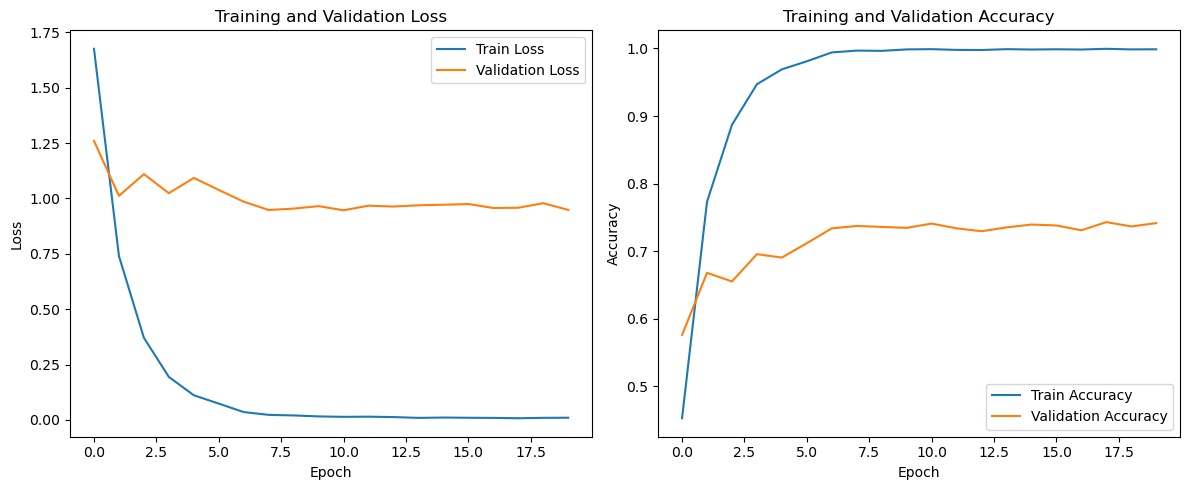


Evaluating model on validation set:
Overall Accuracy: 74.15%
Accuracy of Alza: 84.31%
Accuracy of Aruz: 92.16%
Accuracy of Ativa: 95.00%
Accuracy of Axia: 76.47%
Accuracy of Bezza: 73.53%
Accuracy of Kancil: 96.00%
Accuracy of Myvi: 81.00%
Accuracy of accord: 66.67%
Accuracy of camry: 60.00%
Accuracy of city: 65.00%
Accuracy of civic: 50.00%
Accuracy of corolla: 57.84%
Accuracy of vios: 73.00%
Accuracy of yaris: 67.00%


In [25]:
# Plot training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

# Evaluate the model on the validation set
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Class performance
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Print overall accuracy
    print(f'Overall Accuracy: {100 * correct / total:.2f}%')
    
    # Print class-wise accuracy
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Evaluate the trained model
print("\nEvaluating model on validation set:")
evaluate_model(model, val_loader)

[I 2025-06-04 17:42:36,091] A new study created in memory with name: no-name-93fa6bce-ee72-4584-807b-c89d89d640cd


Using cuda device
Loading dataset...
Classes: ['Alza', 'Aruz', 'Ativa', 'Axia', 'Bezza', 'Kancil', 'Myvi', 'accord', 'camry', 'city', 'civic', 'corolla', 'vios', 'yaris']
Number of training samples: 5627
Number of validation samples: 1412
Epoch 1/10: Train Loss: 1.4009, Train Acc: 0.5347, Val Loss: 1.1511, Val Acc: 0.6239
Epoch 2/10: Train Loss: 0.5489, Train Acc: 0.8079, Val Loss: 0.7268, Val Acc: 0.7635
Epoch 3/10: Train Loss: 0.3177, Train Acc: 0.8950, Val Loss: 0.6015, Val Acc: 0.8229
Epoch 4/10: Train Loss: 0.1789, Train Acc: 0.9438, Val Loss: 0.7381, Val Acc: 0.7861


[I 2025-06-04 17:47:53,093] Trial 0 finished with value: 0.8229461756373938 and parameters: {'batch_size': 32, 'learning_rate': 0.0012022482924695793, 'optimizer': 'Adam', 'weight_decay': 1.2195730004877455e-06, 'freeze_layers': 5, 'dropout_rate': 0.23488980311280466, 'scheduler_factor': 0.17873135991173542, 'scheduler_patience': 4}. Best is trial 0 with value: 0.8229461756373938.


Epoch 5/10: Train Loss: 0.1158, Train Acc: 0.9648, Val Loss: 1.0691, Val Acc: 0.7344
Time limit reached, stopping training.
Epoch 1/10: Train Loss: 1.1818, Train Acc: 0.6366, Val Loss: 0.5313, Val Acc: 0.8336
Epoch 2/10: Train Loss: 0.2532, Train Acc: 0.9250, Val Loss: 0.4211, Val Acc: 0.8548
Epoch 3/10: Train Loss: 0.1252, Train Acc: 0.9634, Val Loss: 0.3733, Val Acc: 0.8867
Epoch 4/10: Train Loss: 0.0812, Train Acc: 0.9774, Val Loss: 0.3175, Val Acc: 0.9051


[I 2025-06-04 17:52:53,919] Trial 1 finished with value: 0.9050991501416431 and parameters: {'batch_size': 32, 'learning_rate': 0.00022667031014222706, 'optimizer': 'Adam', 'weight_decay': 0.0005168679424566225, 'freeze_layers': 5, 'dropout_rate': 0.07387261142045354, 'scheduler_factor': 0.1317303964419264, 'scheduler_patience': 4}. Best is trial 1 with value: 0.9050991501416431.


Epoch 5/10: Train Loss: 0.0499, Train Acc: 0.9860, Val Loss: 0.3898, Val Acc: 0.8895
Time limit reached, stopping training.
Epoch 1/10: Train Loss: 1.0888, Train Acc: 0.6328, Val Loss: 0.6906, Val Acc: 0.8067
Epoch 2/10: Train Loss: 0.2666, Train Acc: 0.9133, Val Loss: 0.4567, Val Acc: 0.8499
Epoch 3/10: Train Loss: 0.1338, Train Acc: 0.9620, Val Loss: 0.4478, Val Acc: 0.8676
Epoch 4/10: Train Loss: 0.0956, Train Acc: 0.9744, Val Loss: 0.5002, Val Acc: 0.8676
Epoch 5/10: Train Loss: 0.0692, Train Acc: 0.9828, Val Loss: 0.4709, Val Acc: 0.8803
Epoch 6/10: Train Loss: 0.0837, Train Acc: 0.9774, Val Loss: 0.3987, Val Acc: 0.8945


[I 2025-06-04 17:58:19,196] Trial 2 finished with value: 0.8944759206798867 and parameters: {'batch_size': 32, 'learning_rate': 0.0009686040884156614, 'optimizer': 'RMSprop', 'weight_decay': 0.00010541736468295282, 'freeze_layers': 7, 'dropout_rate': 0.1032662368585367, 'scheduler_factor': 0.10845521063421777, 'scheduler_patience': 2}. Best is trial 1 with value: 0.9050991501416431.


Epoch 7/10: Train Loss: 0.0586, Train Acc: 0.9794, Val Loss: 0.6955, Val Acc: 0.8173
Time limit reached, stopping training.
Epoch 1/10: Train Loss: 2.5961, Train Acc: 0.1431, Val Loss: 2.5270, Val Acc: 0.2521
Epoch 2/10: Train Loss: 2.4368, Train Acc: 0.3018, Val Loss: 2.3405, Val Acc: 0.3584
Epoch 3/10: Train Loss: 2.1996, Train Acc: 0.3995, Val Loss: 2.0607, Val Acc: 0.4115
Epoch 4/10: Train Loss: 1.8849, Train Acc: 0.4761, Val Loss: 1.7520, Val Acc: 0.4908
Epoch 5/10: Train Loss: 1.5593, Train Acc: 0.5783, Val Loss: 1.4794, Val Acc: 0.5602


[I 2025-06-04 18:03:35,633] Trial 3 finished with value: 0.6218130311614731 and parameters: {'batch_size': 64, 'learning_rate': 0.0009193676701714561, 'optimizer': 'SGD', 'weight_decay': 0.00032182541043566845, 'freeze_layers': 6, 'dropout_rate': 0.21803340808008453, 'scheduler_factor': 0.49297955725784903, 'scheduler_patience': 5}. Best is trial 1 with value: 0.9050991501416431.


Epoch 6/10: Train Loss: 1.2649, Train Acc: 0.6622, Val Loss: 1.2530, Val Acc: 0.6218
Time limit reached, stopping training.
Epoch 1/10: Train Loss: 2.4265, Train Acc: 0.2518, Val Loss: 2.0113, Val Acc: 0.4320
Epoch 2/10: Train Loss: 1.5795, Train Acc: 0.5388, Val Loss: 1.1597, Val Acc: 0.6657
Epoch 3/10: Train Loss: 0.8236, Train Acc: 0.7691, Val Loss: 0.7145, Val Acc: 0.7783
Epoch 4/10: Train Loss: 0.3805, Train Acc: 0.9033, Val Loss: 0.5603, Val Acc: 0.8081


[I 2025-06-04 18:09:13,357] Trial 4 finished with value: 0.8378186968838527 and parameters: {'batch_size': 32, 'learning_rate': 0.0014672324820310528, 'optimizer': 'SGD', 'weight_decay': 1.3506877351327311e-05, 'freeze_layers': 3, 'dropout_rate': 0.19827771580141462, 'scheduler_factor': 0.17670628576037994, 'scheduler_patience': 3}. Best is trial 1 with value: 0.9050991501416431.


Epoch 5/10: Train Loss: 0.1656, Train Acc: 0.9684, Val Loss: 0.4716, Val Acc: 0.8378
Time limit reached, stopping training.


[I 2025-06-04 18:09:54,953] Trial 5 pruned. 


Epoch 1/10: Train Loss: 2.5716, Train Acc: 0.1843, Val Loss: 2.4709, Val Acc: 0.3265


[I 2025-06-04 18:12:32,203] Trial 6 pruned. 


Epoch 1/10: Train Loss: 2.5503, Train Acc: 0.1814, Val Loss: 2.3723, Val Acc: 0.3704
Epoch 1/10: Train Loss: 1.3598, Train Acc: 0.5474, Val Loss: 0.8889, Val Acc: 0.6976


[I 2025-06-04 18:14:52,825] Trial 7 pruned. 


Epoch 2/10: Train Loss: 0.5686, Train Acc: 0.8104, Val Loss: 0.8267, Val Acc: 0.7351


[I 2025-06-04 18:16:01,132] Trial 8 pruned. 


Epoch 1/10: Train Loss: 2.5567, Train Acc: 0.1859, Val Loss: 2.4111, Val Acc: 0.3534


[I 2025-06-04 18:17:16,931] Trial 9 pruned. 


Epoch 1/10: Train Loss: 2.6386, Train Acc: 0.0798, Val Loss: 2.6182, Val Acc: 0.0984


[I 2025-06-04 18:18:25,240] Trial 10 pruned. 


Epoch 1/10: Train Loss: 3.8180, Train Acc: 0.0842, Val Loss: 23.0609, Val Acc: 0.0722


[I 2025-06-04 18:19:08,553] Trial 11 pruned. 


Epoch 1/10: Train Loss: 2.5380, Train Acc: 0.2303, Val Loss: 2.4624, Val Acc: 0.3237
Epoch 1/10: Train Loss: 1.1467, Train Acc: 0.6447, Val Loss: 0.5573, Val Acc: 0.8123
Epoch 2/10: Train Loss: 0.2394, Train Acc: 0.9353, Val Loss: 0.4305, Val Acc: 0.8683
Epoch 3/10: Train Loss: 0.0697, Train Acc: 0.9845, Val Loss: 0.4327, Val Acc: 0.8676
Epoch 4/10: Train Loss: 0.0417, Train Acc: 0.9906, Val Loss: 0.4593, Val Acc: 0.8697
Epoch 5/10: Train Loss: 0.0448, Train Acc: 0.9883, Val Loss: 0.4535, Val Acc: 0.8789
Epoch 6/10: Train Loss: 0.0417, Train Acc: 0.9899, Val Loss: 0.4998, Val Acc: 0.8704


[I 2025-06-04 18:24:33,864] Trial 12 finished with value: 0.8916430594900849 and parameters: {'batch_size': 32, 'learning_rate': 0.00011773495474373333, 'optimizer': 'RMSprop', 'weight_decay': 0.000986533129954383, 'freeze_layers': 7, 'dropout_rate': 0.0946072761366728, 'scheduler_factor': 0.16638470529834948, 'scheduler_patience': 3}. Best is trial 1 with value: 0.9050991501416431.


Epoch 7/10: Train Loss: 0.0178, Train Acc: 0.9959, Val Loss: 0.4137, Val Acc: 0.8916
Time limit reached, stopping training.


[I 2025-06-04 18:25:27,055] Trial 13 pruned. 


Epoch 1/10: Train Loss: 2.4534, Train Acc: 0.2593, Val Loss: 2.1686, Val Acc: 0.4115


[I 2025-06-04 18:26:35,487] Trial 14 pruned. 


Epoch 1/10: Train Loss: 2.6425, Train Acc: 0.0937, Val Loss: 8.0277, Val Acc: 0.0786
Epoch 1/10: Train Loss: 1.1525, Train Acc: 0.6259, Val Loss: 0.5161, Val Acc: 0.8392
Epoch 2/10: Train Loss: 0.3118, Train Acc: 0.9019, Val Loss: 0.3516, Val Acc: 0.8938
Epoch 3/10: Train Loss: 0.1518, Train Acc: 0.9582, Val Loss: 0.3322, Val Acc: 0.9001
Epoch 4/10: Train Loss: 0.1028, Train Acc: 0.9717, Val Loss: 0.2956, Val Acc: 0.9157


[I 2025-06-04 18:32:11,521] Trial 15 finished with value: 0.9157223796033994 and parameters: {'batch_size': 16, 'learning_rate': 0.00010789557536232313, 'optimizer': 'RMSprop', 'weight_decay': 0.00040750323535827527, 'freeze_layers': 2, 'dropout_rate': 0.4666802835860424, 'scheduler_factor': 0.392195182888112, 'scheduler_patience': 3}. Best is trial 15 with value: 0.9157223796033994.


Epoch 5/10: Train Loss: 0.0779, Train Acc: 0.9780, Val Loss: 0.8825, Val Acc: 0.8428
Time limit reached, stopping training.


[I 2025-06-04 18:33:19,841] Trial 16 pruned. 


Epoch 1/10: Train Loss: 1.8905, Train Acc: 0.4100, Val Loss: 0.8804, Val Acc: 0.7217
Epoch 1/10: Train Loss: 1.0764, Train Acc: 0.6506, Val Loss: 0.5190, Val Acc: 0.8265
Epoch 2/10: Train Loss: 0.2978, Train Acc: 0.9056, Val Loss: 0.4994, Val Acc: 0.8605
Epoch 3/10: Train Loss: 0.1522, Train Acc: 0.9550, Val Loss: 0.2997, Val Acc: 0.9072
Epoch 4/10: Train Loss: 0.1091, Train Acc: 0.9693, Val Loss: 0.4105, Val Acc: 0.8817


[I 2025-06-04 18:39:02,185] Trial 17 finished with value: 0.9072237960339944 and parameters: {'batch_size': 16, 'learning_rate': 0.00017496863508396928, 'optimizer': 'RMSprop', 'weight_decay': 1.9921797837408937e-05, 'freeze_layers': 1, 'dropout_rate': 0.3842580888937494, 'scheduler_factor': 0.42993978100466707, 'scheduler_patience': 3}. Best is trial 15 with value: 0.9157223796033994.


Epoch 5/10: Train Loss: 0.0973, Train Acc: 0.9687, Val Loss: 0.3536, Val Acc: 0.9044
Time limit reached, stopping training.


[I 2025-06-04 18:40:09,299] Trial 18 pruned. 


Epoch 1/10: Train Loss: 2.0305, Train Acc: 0.3812, Val Loss: 1.2472, Val Acc: 0.6686
Epoch 1/10: Train Loss: 1.1289, Train Acc: 0.6453, Val Loss: 0.5147, Val Acc: 0.8286


[I 2025-06-04 18:42:30,248] Trial 19 pruned. 


Epoch 2/10: Train Loss: 0.2826, Train Acc: 0.9172, Val Loss: 0.5623, Val Acc: 0.8336
Best trial:
  Value: 0.9157223796033994
  Params: 
    batch_size: 16
    learning_rate: 0.00010789557536232313
    optimizer: RMSprop
    weight_decay: 0.00040750323535827527
    freeze_layers: 2
    dropout_rate: 0.4666802835860424
    scheduler_factor: 0.392195182888112
    scheduler_patience: 3

Training final model with best hyperparameters...


Epoch 1/20 [Val]: 100%|██████████| 89/89 [00:16<00:00,  5.46it/s, loss=0.619, acc=0.858]  


Epoch 1/20: Train Loss: 1.2146, Train Acc: 0.6149, Val Loss: 0.4557, Val Acc: 0.8576


Epoch 2/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.77it/s, loss=0.624, acc=0.867]   


Epoch 2/20: Train Loss: 0.3027, Train Acc: 0.9129, Val Loss: 0.4271, Val Acc: 0.8669


Epoch 3/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.80it/s, loss=1.11, acc=0.902]   


Epoch 3/20: Train Loss: 0.1267, Train Acc: 0.9653, Val Loss: 0.3369, Val Acc: 0.9016


Epoch 4/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.80it/s, loss=0.58, acc=0.897]    


Epoch 4/20: Train Loss: 0.0926, Train Acc: 0.9742, Val Loss: 0.4180, Val Acc: 0.8973


Epoch 5/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.84it/s, loss=0.692, acc=0.912]   


Epoch 5/20: Train Loss: 0.0762, Train Acc: 0.9801, Val Loss: 0.3274, Val Acc: 0.9122


Epoch 6/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.78it/s, loss=0.132, acc=0.911]   


Epoch 6/20: Train Loss: 0.0716, Train Acc: 0.9787, Val Loss: 0.3533, Val Acc: 0.9108


Epoch 7/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.81it/s, loss=0.202, acc=0.911]   


Epoch 7/20: Train Loss: 0.0544, Train Acc: 0.9860, Val Loss: 0.3568, Val Acc: 0.9108


Epoch 8/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.81it/s, loss=1.26, acc=0.906]    


Epoch 8/20: Train Loss: 0.0619, Train Acc: 0.9813, Val Loss: 0.3688, Val Acc: 0.9058


Epoch 9/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.83it/s, loss=0.409, acc=0.926]   


Epoch 9/20: Train Loss: 0.0501, Train Acc: 0.9861, Val Loss: 0.2737, Val Acc: 0.9263


Epoch 10/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.77it/s, loss=0.0985, acc=0.918]  


Epoch 10/20: Train Loss: 0.0449, Train Acc: 0.9874, Val Loss: 0.3236, Val Acc: 0.9178


Epoch 11/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.78it/s, loss=0.442, acc=0.895]   


Epoch 11/20: Train Loss: 0.0388, Train Acc: 0.9890, Val Loss: 0.4486, Val Acc: 0.8952


Epoch 12/20 [Val]: 100%|██████████| 89/89 [00:16<00:00,  5.56it/s, loss=0.321, acc=0.914]   


Epoch 12/20: Train Loss: 0.0476, Train Acc: 0.9849, Val Loss: 0.3394, Val Acc: 0.9143


Epoch 13/20 [Val]: 100%|██████████| 89/89 [00:17<00:00,  5.17it/s, loss=0.185, acc=0.902]   


Epoch 13/20: Train Loss: 0.0485, Train Acc: 0.9872, Val Loss: 0.4046, Val Acc: 0.9016


Epoch 14/20 [Val]: 100%|██████████| 89/89 [00:16<00:00,  5.37it/s, loss=0.145, acc=0.931]   


Epoch 14/20: Train Loss: 0.0207, Train Acc: 0.9948, Val Loss: 0.2978, Val Acc: 0.9313


Epoch 15/20 [Val]: 100%|██████████| 89/89 [00:17<00:00,  5.08it/s, loss=0.0132, acc=0.938]  


Epoch 15/20: Train Loss: 0.0103, Train Acc: 0.9977, Val Loss: 0.2812, Val Acc: 0.9377


Epoch 16/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.71it/s, loss=0.00703, acc=0.931] 


Epoch 16/20: Train Loss: 0.0067, Train Acc: 0.9986, Val Loss: 0.3286, Val Acc: 0.9306


Epoch 17/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.59it/s, loss=0.24, acc=0.928]    


Epoch 17/20: Train Loss: 0.0071, Train Acc: 0.9977, Val Loss: 0.3187, Val Acc: 0.9285


Epoch 18/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.76it/s, loss=0.104, acc=0.938]   


Epoch 18/20: Train Loss: 0.0068, Train Acc: 0.9979, Val Loss: 0.2745, Val Acc: 0.9384


Epoch 19/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.74it/s, loss=0.155, acc=0.943]   


Epoch 19/20: Train Loss: 0.0027, Train Acc: 0.9993, Val Loss: 0.2617, Val Acc: 0.9433


Epoch 20/20 [Val]: 100%|██████████| 89/89 [00:15<00:00,  5.73it/s, loss=0.0181, acc=0.944]  


Epoch 20/20: Train Loss: 0.0030, Train Acc: 0.9989, Val Loss: 0.2746, Val Acc: 0.9441


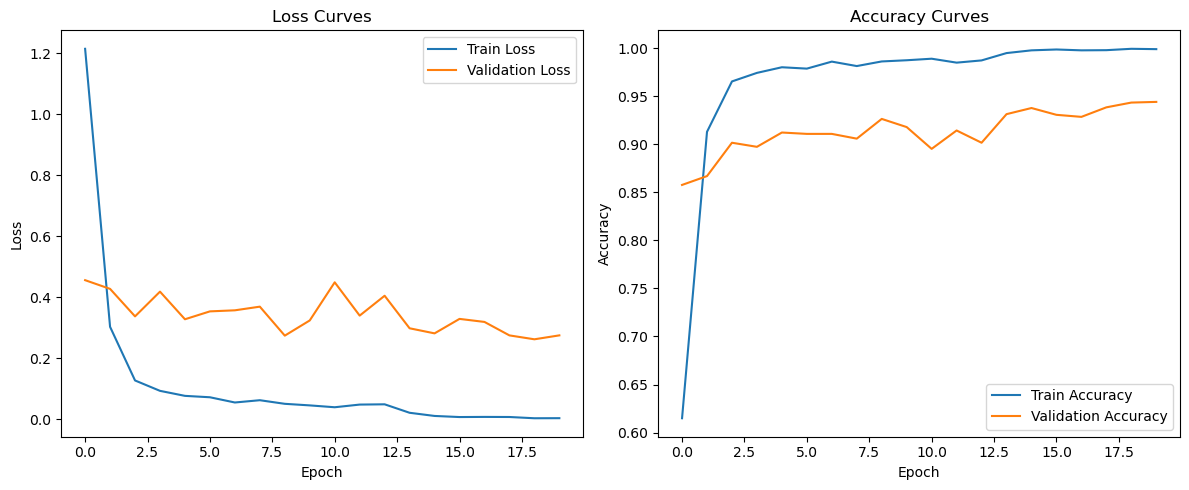

Final model trained and saved as 'car_brand_best_model.pth'


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Set paths
data_dir = "dataset/Car-Model-Data"
num_classes = 14

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading dataset...")
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

# Print class information
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Function to create and train model with specific hyperparameters
def objective(trial):
    # Hyperparameters to tune
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    freeze_layers = trial.suggest_int("freeze_layers", 0, 8)  # How many ResNet blocks to freeze
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    
    # Additional hyperparameters
    scheduler_factor = trial.suggest_float("scheduler_factor", 0.1, 0.5)
    scheduler_patience = trial.suggest_int("scheduler_patience", 1, 5)
    
    # Create dataloaders with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Load pre-trained ResNet-50 model
    model = models.resnet50(weights='IMAGENET1K_V2')
    
    # Freeze early layers based on trial suggestion
    modules = list(model.children())[:-2]  # Exclude final avg pool and fc
    for i in range(freeze_layers):
        if i < len(modules):
            for param in modules[i].parameters():
                param.requires_grad = False
    
    # Replace the final fully connected layer with dropout
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)
    
    # Set up loss function
    criterion = nn.CrossEntropyLoss()
    
    # Set up optimizer based on trial suggestion
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    else:  # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Set up scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
    )
    
    # Set maximum training time (e.g., 5 minutes per trial)
    max_train_time = 5 * 60  # 5 minutes in seconds
    start_time = time.time()
    
    # Training loop with early stopping
    best_val_acc = 0.0
    epochs_without_improvement = 0
    early_stopping_patience = 3
    max_epochs = 10  # Limit epochs for hyperparameter search
    
    for epoch in range(max_epochs):
        # Check if we've exceeded time limit
        if time.time() - start_time > max_train_time:
            print("Time limit reached, stopping training.")
            break
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{max_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
        
        # Report intermediate value for pruning
        trial.report(epoch_val_acc, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping logic
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    return best_val_acc

# Create Optuna study
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)  # Adjust number of trials based on time constraints

# Print best trial information
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualize results
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)

# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
best_params = study.best_params

# Get the best batch size
batch_size = best_params["batch_size"]

# Create dataloaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet-50 model
model = models.resnet50(weights='IMAGENET1K_V2')

# Apply best freezing strategy
freeze_layers = best_params["freeze_layers"]
modules = list(model.children())[:-2]
for i in range(freeze_layers):
    if i < len(modules):
        for param in modules[i].parameters():
            param.requires_grad = False

# Replace the final fully connected layer with best dropout
dropout_rate = best_params["dropout_rate"]
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer with best parameters
optimizer_name = best_params["optimizer"]
learning_rate = best_params["learning_rate"]
weight_decay = best_params["weight_decay"]

if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
else:  # RMSprop
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set up best scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=best_params["scheduler_factor"], 
    patience=best_params["scheduler_patience"]
)

# Train the final model with the full training regime
num_epochs = 20  # Use your original number of epochs for final training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_bar.set_postfix({'loss': loss.item(), 'acc': val_correct/val_total})
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Update learning rate
    scheduler.step(epoch_val_loss)

# Save the final model
torch.save(model.state_dict(), 'car_brand_best_model.pth')

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

print("Final model trained and saved as 'car_brand_best_model.pth'")

In [3]:
# Evaluate the model on the validation set
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Class performance
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Print overall accuracy
    print(f'Overall Accuracy: {100 * correct / total:.2f}%')
    
    # Print class-wise accuracy
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Evaluate the trained model
print("\nEvaluating model on validation set:")
evaluate_model(model, val_loader)


Evaluating model on validation set:
Overall Accuracy: 94.41%
Accuracy of Alza: 98.04%
Accuracy of Aruz: 98.04%
Accuracy of Ativa: 100.00%
Accuracy of Axia: 95.10%
Accuracy of Bezza: 97.06%
Accuracy of Kancil: 100.00%
Accuracy of Myvi: 97.00%
Accuracy of accord: 93.14%
Accuracy of camry: 91.00%
Accuracy of city: 94.00%
Accuracy of civic: 82.00%
Accuracy of corolla: 87.25%
Accuracy of vios: 97.00%
Accuracy of yaris: 92.00%


In [4]:
# Save the model
torch.save(model.state_dict(), 'best_car_brand_resnet50.pth')
print("Model saved to best_car_brand_resnet50.pth")

Model saved to best_car_brand_resnet50.pth
